In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
import xgboost

np.random.seed(26)
sns.set_theme(style="whitegrid")

Import MNIST dataset

In [2]:
from sklearn.datasets import fetch_openml

In [3]:
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

EDA:

In [4]:
mnist.data.shape

(70000, 784)

In [5]:
mnist.data.min(), mnist.data.max()

(np.int64(0), np.int64(255))

In [6]:
images = mnist["data"]
labels = mnist["target"].astype(np.uint8)

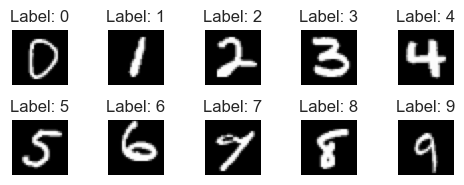

In [7]:
# Display a grid of a random sample image for each digit
def sample_images(images, labels):
    unique_labels = np.unique(labels)
    plt.figure(figsize=(5, 2))

    for i, label in enumerate(unique_labels):
        # Find all indices of the current label
        indices = np.where(labels == label)[0]
        # Show a random index each time
        random_index = random.choice(indices)

        plt.subplot(2, 5, i + 1)
        # Reshape image to 28x28 and display in grayscale
        image = images[random_index].reshape(28, 28)
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

sample_images(images, labels)

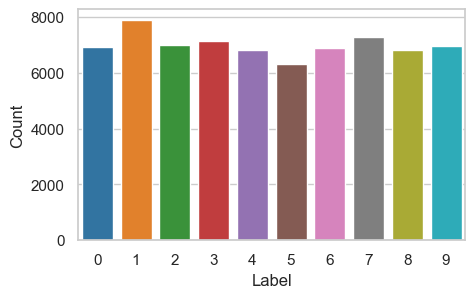

In [8]:
plt.figure(figsize=(5, 3))
sns.barplot(x=np.unique(labels), y=np.bincount(labels), hue=np.unique(labels), palette="tab10", legend=False)
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

Preprocess and split data into training, validation, and test datasets:

In [9]:
X = mnist.data
y = mnist.target.astype(np.uint8)

# Flatten the images
X = X.reshape(X.shape[0], 784)

# Normalize pixel values
X = X.astype('float32') / 255.0

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state=26)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=26)

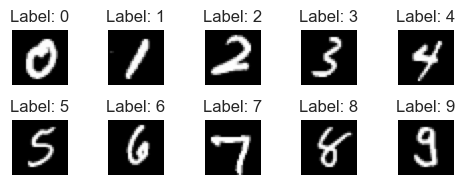

In [10]:
images = X
labels = y

# Display a grid of a random sample image for each digit
def sample_images(images, labels):
    unique_labels = np.unique(labels)
    plt.figure(figsize=(5, 2))

    for i, label in enumerate(unique_labels):
        # Find all indices of the current label
        indices = np.where(labels == label)[0]
        # Show a random index each time
        random_index = random.choice(indices)

        plt.subplot(2, 5, i + 1)
        # Reshape image to 28x28 and display in grayscale
        image = images[random_index].reshape(28, 28)
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

sample_images(images, labels)

In [11]:
X_train.shape, X_val.shape, X_test.shape

((56700, 784), (6300, 784), (7000, 784))

Models:

In [12]:
rfc = RandomForestClassifier(n_estimators=100, random_state=26)
etc = ExtraTreesClassifier(n_estimators=100, random_state=26)
xgb = xgboost.XGBClassifier(random_state=26)


In [13]:
# Random forest
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=26)

In [14]:
y_pred_rfc = rfc.predict(X_val)
accuracy_rfc = accuracy_score(y_val, y_pred_rfc)
print(f"Random Forest Classifier accuracy: {accuracy_rfc:.4f}")

Random Forest Classifier accuracy: 0.9657


In [15]:
# Extra trees
etc.fit(X_train, y_train)

ExtraTreesClassifier(random_state=26)

In [16]:
y_pred_etc = etc.predict(X_val)
accuracy_etc = accuracy_score(y_val, y_pred_etc)
print(f"Extra Trees Classifier accuracy: {accuracy_etc:.4f}")

Extra Trees Classifier accuracy: 0.9671


In [17]:
# XGBoost
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [18]:
y_pred_xgb = xgb.predict(X_val)
accuracy_xgb = accuracy_score(y_val, y_pred_xgb)
print(f"XGBoost Classifier accuracy: {accuracy_xgb:.4f}")

XGBoost Classifier accuracy: 0.9743


In [19]:
# Find the best parameters for the XGBoost model
model = xgboost.XGBClassifier(objective='multi:softmax', num_class=10, random_state=26, device='cuda',
                              early_stopping_rounds=10, eval_metric='mlogloss', n_estimators=1000)

params = {    
    'learning_rate': np.arange(0.01, 0.15, 0.01),
    'max_depth': np.arange(3, 7),    
    'subsample': np.arange(0.7, 1.0, 0.05),
    'colsample_bytree': np.arange(0.7, 1.0, 0.05),
    'gamma': np.arange(0, 3)
    }

search = RandomizedSearchCV(
    model,
    param_distributions=params,
    n_iter=20,
    cv=3,
    random_state=26,
    refit=True,
    verbose=2)

search.fit(X_train, y_train, eval_set=[(X_val, y_val)])

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[0]	validation_0-mlogloss:2.05231
[1]	validation_0-mlogloss:1.86829
[2]	validation_0-mlogloss:1.71677
[3]	validation_0-mlogloss:1.59012
[4]	validation_0-mlogloss:1.48197
[5]	validation_0-mlogloss:1.38720
[6]	validation_0-mlogloss:1.30297
[7]	validation_0-mlogloss:1.22731
[8]	validation_0-mlogloss:1.15950
[9]	validation_0-mlogloss:1.09813
[10]	validation_0-mlogloss:1.04170
[11]	validation_0-mlogloss:0.98850
[12]	validation_0-mlogloss:0.94009
[13]	validation_0-mlogloss:0.89501
[14]	validation_0-mlogloss:0.85405
[15]	validation_0-mlogloss:0.81581
[16]	validation_0-mlogloss:0.78101
[17]	validation_0-mlogloss:0.74756
[18]	validation_0-mlogloss:0.71694
[19]	validation_0-mlogloss:0.68803
[20]	validation_0-mlogloss:0.66094
[21]	validation_0-mlogloss:0.63550
[22]	validation_0-mlogloss:0.61216
[23]	validation_0-mlogloss:0.59082
[24]	validation_0-mlogloss:0.57044
[25]	validation_0-mlogloss:0.55098
[26]	validation_0-mlogloss:0.53268
[27]

c:\Users\AmsSu\anaconda3\envs\python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:41:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.9000000000000001, gamma=0, learning_rate=0.08, max_depth=5, subsample=0.8500000000000001; total time= 1.1min
[0]	validation_0-mlogloss:2.05303
[1]	validation_0-mlogloss:1.86820
[2]	validation_0-mlogloss:1.71688
[3]	validation_0-mlogloss:1.59185
[4]	validation_0-mlogloss:1.48475
[5]	validation_0-mlogloss:1.39078
[6]	validation_0-mlogloss:1.30750
[7]	validation_0-mlogloss:1.23244
[8]	validation_0-mlogloss:1.16622
[9]	validation_0-mlogloss:1.10535
[10]	validation_0-mlogloss:1.04891
[11]	validation_0-mlogloss:0.99514
[12]	validation_0-mlogloss:0.94576
[13]	validation_0-mlogloss:0.90106
[14]	validation_0-mlogloss:0.85914
[15]	validation_0-mlogloss:0.82146
[16]	validation_0-mlogloss:0.78586
[17]	validation_0-mlogloss:0.75232
[18]	validation_0-mlogloss:0.72140
[19]	validation_0-mlogloss:0.69206
[20]	validation_0-mlogloss:0.66516
[21]	validation_0-mlogloss:0.63962
[22]	validation_0-mlogloss:0.61565
[23]	validation_0-mlogloss:0.59344
[24]	validation_0-mlogloss:0.5728

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device='cuda',
                                           early_stopping_rounds=10,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learnin...
                                           num_class=10, num_parallel_tree=None, ...),
                   n_iter=20,
                   param_distributions={'colsample_bytree': array([0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
                                        'gamma': array([0, 1, 2]),
                                        'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14]),
                                        'max_depth': array([3, 4, 5, 6]),
                                        'subsample': array([0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                   random_state=26, verbose=2)

In [29]:
# List the best parameters for the final model found using RandomizedSearchCV
print("Best Parameters:", search.best_params_)

Best Parameters: {'subsample': np.float64(0.8500000000000001), 'max_depth': np.int64(5), 'learning_rate': np.float64(0.08), 'gamma': np.int64(0), 'colsample_bytree': np.float64(0.9000000000000001)}


In [44]:
print("Best Score:", search.best_score_)

Best Score: 0.9759611992945326


In [45]:
print("Best Estimator:", search.best_estimator_)

Best Estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.9000000000000001), device='cuda',
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, gamma=np.int64(0),
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=np.float64(0.08),
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=np.int64(5), max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None, num_class=10,
              num_parallel_tree=None, ...)


In [40]:
# Retrain the best model on the full training set
best_model = search.best_estimator_
best_model.set_params(early_stopping_rounds=None)
final_model = best_model.fit(X_train_full, y_train_full)

In [41]:
# Save model
joblib.dump(final_model, "models/xgb_model_mnist.pkl") 

['models/xgb_model_mnist.pkl']

In [42]:
# Load model
final_model = joblib.load("models/xgb_model_mnist.pkl")

In [43]:
# Test the final model on the test set
y_pred_final = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_final)
print(f"Final model accuracy: {accuracy:.4f}")

Final model accuracy: 0.9801


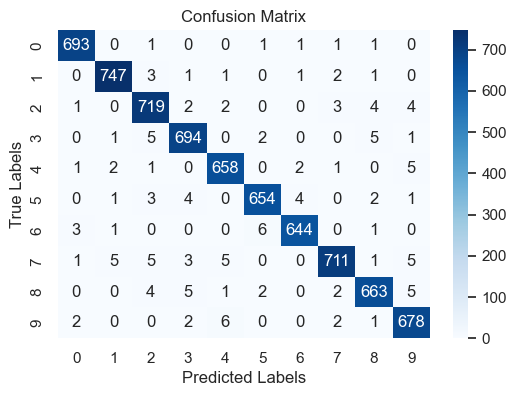

In [46]:
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(6, 4))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [47]:
report = classification_report(y_test, y_pred_final)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       698
           1       0.99      0.99      0.99       756
           2       0.97      0.98      0.97       735
           3       0.98      0.98      0.98       708
           4       0.98      0.98      0.98       670
           5       0.98      0.98      0.98       669
           6       0.99      0.98      0.99       655
           7       0.98      0.97      0.98       736
           8       0.98      0.97      0.97       682
           9       0.97      0.98      0.98       691

    accuracy                           0.98      7000
   macro avg       0.98      0.98      0.98      7000
weighted avg       0.98      0.98      0.98      7000

